In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from ast import literal_eval
from scipy import stats
%matplotlib inline

In [74]:
path = "C:\\Users\\faris\\Desktop\\Udacity Data Scientest\\Project 1\\Boston"

## Reading files of each city

In [75]:
dict_dfs = {}
for file in os.listdir(path):
    dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)

In [76]:
dict_dfs.keys()

dict_keys(['calendar', 'listings', 'reviews'])

# Special treatment for the reviews dataframe to asses the postivity and negtivity of each comment, as the computation takes long time it will be save as the new csv file

In [5]:
#Dropping rows with null comment
dict_dfs["reviews"] = dict_dfs["reviews"].dropna(subset=["comments"], axis = 0).reset_index(drop = True)

#https://gist.github.com/mkulakowski2/4289437
#The above link contains a text file for most used postive adjectives, which will be used to find the postivity of reviews
postive = pd.read_csv("Postive.csv")
postive = list(postive["ADJ"])

#https://gist.github.com/mkulakowski2/4289441
#The above link contains a text file for most used negtive adjectives, which will be used to find the negtivity of reviews
negtive = pd.read_csv("Negtive.csv")
negtive = list(negtive["ADJ"])

#lists which will have the the ratio of postive or negtive adjective to the total number of words in the comment
lst_postive_ratio = []
lst_negtive_ratio = []


#iterating over all comments in the dataframe
for comment in range(dict_dfs["reviews"].shape[0]):
    
    #getting all the words in the comment
    lst_of_comment_words = dict_dfs["reviews"]["comments"].iloc[comment].split(" ")
    #counter of postive or negtive words
    postive_count = 0
    negtive_count = 0
    
    for word in lst_of_comment_words:
        if word in postive:
            postive_count += 1
        elif word in negtive:
            negtive_count += 1
    #calculating the ratio of postive or negtive to the total number of words in the comment
    postive_ratio = postive_count/len(lst_of_comment_words)
    negtive_ratio = negtive_count/len(lst_of_comment_words)
    
    lst_postive_ratio.append(postive_ratio)
    lst_negtive_ratio.append(negtive_ratio)
    
    print(comment)
    
dict_dfs["reviews"]["postive_ratio"] = lst_postive_ratio
dict_dfs["reviews"]["negtive_ratio"] = lst_negtive_ratio

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078


3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725


KeyboardInterrupt: 

In [ ]:
dict_dfs["reviews"].to_csv(path + "\\" + "reviews.csv")

In [ ]:
len(lst_postive_ratio)

# General Functions

In [77]:
# A function which reads the CSVs in a path and return a dictinoray of all dataframes
def reading_dfs(path = "C:\\Users\\faris\\Desktop\\Udacity Data Scientest\\Project 1\\Boston"):
    dict_dfs = {}
    for file in os.listdir(path):
        dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)
        
    return dict_dfs

In [78]:
# A function to clean the calendar df
def clean_calendar_df(df):
    #Transforming the calender data to the availability rate per id
    df = pd.DataFrame(df.groupby(["listing_id"])["available"].value_counts(normalize=True)).rename(columns = {"available":"count"}).reset_index()
    df = df.rename(columns = {"listing_id":"id"})

    #Filtering the data to get only the percentge when it is not available
    df = df[df["available"] == "f"].reset_index(drop = True)
    
    return df

In [79]:
# A function to clean the listing df
def clean_listings_df(df,extra_columns = []): #extra_columns will be added for trial 3
    # Droping all rows which have the response value as null
    df = df.dropna(subset = ["not_available_rate"],axis = 0).reset_index(drop = True)

    # Changing house_rules column: Assign True if the propertey have house rules, False if it donse not have
    df["house_rules"] = df["house_rules"].apply(lambda x: "t" if "str" in str(type(x)) else "f")

    # Changing host_since column to be the diffrence between the most recent date in the column and the date, 
    # this will be much eaiser to interpret
    df["host_since"] = pd.to_datetime(df["host_since"]).apply(lambda x: (pd.to_datetime(df["host_since"]).max() - x).days)

    #Changing some columns to float
    df["host_response_rate"] = df["host_response_rate"].str[:-1].apply(float)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].str[:-1].apply(float)
    #These columns required removing a comma and $ to be converted to float
    for col in ['price', 'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee','extra_people']:
        df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


    #Getting the response value and the features matrix
    y = df["not_available_rate"]
    X = df[["house_rules","host_since","host_response_time","host_response_rate",
                              "host_acceptance_rate","host_is_superhost","host_listings_count","host_verifications",
                              "host_identity_verified",'neighbourhood_cleansed',
                              'is_location_exact', 'property_type', 'room_type', 'accommodates','bathrooms', 
                              'bedrooms', 'beds', 'bed_type','price', 'weekly_price', 'monthly_price', 
                              'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
                                'maximum_nights','number_of_reviews','instant_bookable','cancellation_policy', 
                              'require_guest_profile_picture','require_guest_phone_verification',"review_scores_rating"] + extra_columns].copy()

    return X,y

In [80]:
# A function which transform catgorical data into dummy columns
def transfrom_catgorical(df):
    cat_columns = list(df.select_dtypes(include = ["object"]).columns)
    for col in cat_columns:
        if col == "host_verifications": #This column treatment will be diffrent as it have list in each cell
            df = pd.concat([df.drop(col, axis = 1),pd.get_dummies(df[col].apply(lambda x: literal_eval(x)).explode(),prefix=col,prefix_sep="_").groupby(level=0).sum()],axis = 1).copy()
        else:
            df = pd.concat([df.drop(col, axis = 1),pd.get_dummies(df[col],prefix=col,prefix_sep="_")],axis = 1).copy()
    
    return df

In [81]:
#A function which takes X and y and generate a linear regresion model
def linear_reg(X,y):
    #Split data into training and test data, and fit a linear model
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
    lm_model = LinearRegression(normalize=True)

    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)# Predictions here
    r2_test = r2_score(y_test, y_test_preds) # Rsquared here


    return lm_model,r2_test

In [82]:
#A function which takes the model cofficients,X, and y to produce a table of coffiecents and P-values
def coef_weights_and_p(coefficients, X,y):
    '''
    This function is copied from the Udacity notebooks of this course
    '''
    #https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/
    #Getting the p-values to asses the significance of each coffecent, the source of the code is the link above

    lm = LinearRegression()
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)
    new_X = np.append(np.ones((len(X),1)), X, axis=1)
    M_S_E = (sum((y-predictions)**2))/(len(new_X)-len(new_X[0]))
    v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
    s_b = np.sqrt(v_b)
    t_b = params/ s_b
    p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
    p_val = np.round(p_val,3)

    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df["p_val"] = list(p_val)[1:]
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    return coefs_df

## Question 1: What is the main contributers for a high reservations ?

# Trial 1

### It will be assumed that if the propertey is not avilable on a certin day then it is resrved, which means the lower the availability rate the better it is

In [83]:
dict_dfs = reading_dfs()

In [84]:
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

In [85]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

## Cleaning the data and choosing usable features

In [86]:
X,y = clean_listings_df(dict_dfs["listings"])

<ipython-input-79-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


## Transforming catgorical values to multiple columns

In [87]:
X = transfrom_catgorical(X)

## Imputing values into null cells for quantitative columns

In [88]:
#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating"]:
    X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating"]:
    X[col] = X[col].fillna(0)
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    X[col] = X[col].fillna(X[col].dropna().mean())

# Building a linear regresion model

In [89]:
model,r2 = linear_reg(X,y)

In [90]:
r2

-1.2745495084205239e+25

In [91]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

<ipython-input-82-14bcb25ec7ef>:16: RuntimeWarning: invalid value encountered in sqrt
  s_b = np.sqrt(v_b)


In [92]:
#producing a list of significant coffecients which have a p-value less then 0.1 for trial 2
lst_of_sgnificant = list(coefs_df[coefs_df["p_val"] <= 0.1]["est_int"])

## Significant feauters are the ones with a p-value <= 0.1

# The large r squared value might be an indicator for an overfitted model, some of the features will be removed from the model based on the P-value

# Trial 2

In [93]:
dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

In [94]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [95]:
X,y = clean_listings_df(dict_dfs["listings"])

<ipython-input-79-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


In [96]:
X = transfrom_catgorical(X)

In [97]:
#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [98]:
#Getting only the feauters which were significant in the first model
X = X[lst_of_sgnificant].copy()

In [99]:
model,r2 = linear_reg(X,y)

In [100]:
r2

0.222346816437465

In [101]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [102]:
coefs_df

,est_int,coefs,abs_coefs,p_val
0,property_type_Camper/RV,-0.807426,0.807426,0.019
5,host_response_time_within an hour,-0.388198,0.388198,0.000
3,host_response_time_within a few hours,-0.368597,0.368597,0.000
8,host_verifications_manual_offline,0.299081,0.299081,0.000
6,host_response_time_within a day,-0.294904,0.294904,0.000
4,property_type_Other,-0.273304,0.273304,0.027
2,host_response_time_a few days or more,-0.270044,0.270044,0.013
1,property_type_Bed & Breakfast,-0.237974,0.237974,0.000
9,review_scores_rating_filled,-0.237688,0.237688,0.000
10,host_verifications_email,-0.161178,0.161178,0.002


# a much better r squared value was obtained

# Trial 3

## Adding the mean of postive and negtive ratios for the predector matrix X 

In [103]:
dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

In [104]:
#Group reviews dataframe by the listing_id and get the mean of postive and negtive ratios
dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()
dict_dfs["reviews"].rename(columns = {"listing_id": "id","postive_ratio":"mean_postive_ratio","negtive_ratio":"mean_negtive_ratio"}, inplace = True)

<ipython-input-104-8b657034e4fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()


In [105]:
#Adding an extra column to the lisiting dataset which have the response value: the mean of postive and negtive ratios of the comments 
dict_dfs["listings"]["mean_postive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_postive_ratio"])
dict_dfs["listings"]["mean_negtive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_negtive_ratio"])

In [106]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [107]:
X,y = clean_listings_df(dict_dfs["listings"], extra_columns=["mean_postive_ratio","mean_negtive_ratio"])

<ipython-input-79-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


In [108]:
X = transfrom_catgorical(X)

In [109]:
#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating","mean_postive_ratio","mean_negtive_ratio"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating","mean_postive_ratio","mean_negtive_ratio"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [110]:
#Getting only the feauters which were significant in the first model
lst_of_sgnificant = lst_of_sgnificant + ["mean_postive_ratio","mean_negtive_ratio"]
X = X[lst_of_sgnificant].copy()

In [111]:
model,r2 = linear_reg(X,y)

In [112]:
r2

0.21337712576332024

In [113]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [114]:
coefs_df

,est_int,coefs,abs_coefs,p_val
23,mean_negtive_ratio,-1.374090,1.374090,0.439
22,mean_postive_ratio,0.874244,0.874244,0.056
0,property_type_Camper/RV,-0.806971,0.806971,0.019
5,host_response_time_within an hour,-0.387378,0.387378,0.000
3,host_response_time_within a few hours,-0.365598,0.365598,0.000
8,host_verifications_manual_offline,0.298955,0.298955,0.000
6,host_response_time_within a day,-0.293917,0.293917,0.000
2,host_response_time_a few days or more,-0.281770,0.281770,0.011
4,property_type_Other,-0.248645,0.248645,0.035
1,property_type_Bed & Breakfast,-0.234807,0.234807,0.000


# Trial 4

## What happens if merged mean_postive_ratio and mean_negtive_ratio into one column

In [115]:
dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

In [116]:
#Group reviews dataframe by the listing_id and get the mean of postive and negtive ratios
dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()
dict_dfs["reviews"].rename(columns = {"listing_id": "id","postive_ratio":"mean_postive_ratio","negtive_ratio":"mean_negtive_ratio"}, inplace = True)

<ipython-input-116-8b657034e4fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()


In [117]:
#Adding an extra column to the lisiting dataset which have the response value: the mean of postive and negtive ratios of the comments 
dict_dfs["listings"]["mean_postive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_postive_ratio"])
dict_dfs["listings"]["mean_negtive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_negtive_ratio"])
dict_dfs["listings"]["comments_postivity"] = dict_dfs["listings"]["mean_postive_ratio"] - dict_dfs["listings"]["mean_negtive_ratio"] 

In [118]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [119]:
X,y = clean_listings_df(dict_dfs["listings"], extra_columns=["comments_postivity"])

<ipython-input-79-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


In [120]:
X = transfrom_catgorical(X)

In [121]:
#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating","comments_postivity"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating","comments_postivity"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [122]:
lst_of_sgnificant = ['property_type_Camper/RV',
 'property_type_Bed & Breakfast',
 'host_response_time_a few days or more',
 'host_response_time_within a few hours',
 'property_type_Other',
 'host_response_time_within an hour',
 'host_response_time_within a day',
 'host_verifications_weibo',
 'host_verifications_manual_offline',
 'review_scores_rating_filled',
 'host_verifications_email',
 'monthly_price_filled',
 'host_verifications_facebook',
 'bedrooms',
 'review_scores_rating',
 'number_of_reviews',
 'host_response_rate',
 'cleaning_fee',
 'host_acceptance_rate',
 'price',
 'host_listings_count',
 'host_since']

In [123]:
#Getting only the feauters which were significant in the first model
lst_of_sgnificant = lst_of_sgnificant + ["comments_postivity","comments_postivity_filled"]
X = X[lst_of_sgnificant].copy()

In [124]:
model,r2 = linear_reg(X,y)

In [125]:
r2

0.21309317938891292

In [126]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [127]:
coefs_df

,est_int,coefs,abs_coefs,p_val
22,comments_postivity,1.015225,1.015225,0.018
0,property_type_Camper/RV,-0.806395,0.806395,0.019
5,host_response_time_within an hour,-0.386524,0.386524,0.000
3,host_response_time_within a few hours,-0.364173,0.364173,0.000
8,host_verifications_manual_offline,0.299795,0.299795,0.000
6,host_response_time_within a day,-0.293517,0.293517,0.000
2,host_response_time_a few days or more,-0.283806,0.283806,0.011
4,property_type_Other,-0.251033,0.251033,0.033
1,property_type_Bed & Breakfast,-0.233642,0.233642,0.000
10,host_verifications_email,-0.163987,0.163987,0.002


## Q1: What are the availabilty rates for Airbnbs in Boston

In [129]:
#Readiing dataframes
dict_dfs = {}
for file in os.listdir(path):
    dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)

In [148]:
#transfrom the data to be aggregated based on month and year
dict_dfs["calendar"]["year_month"] = pd.to_datetime(dict_dfs["calendar"]["date"]).dt.strftime('%Y-%m')
dict_dfs["calendar"] = pd.DataFrame(dict_dfs["calendar"].groupby(["year_month"]).available.value_counts(normalize=True)).rename(columns = {"available":"available_rate"}).reset_index()

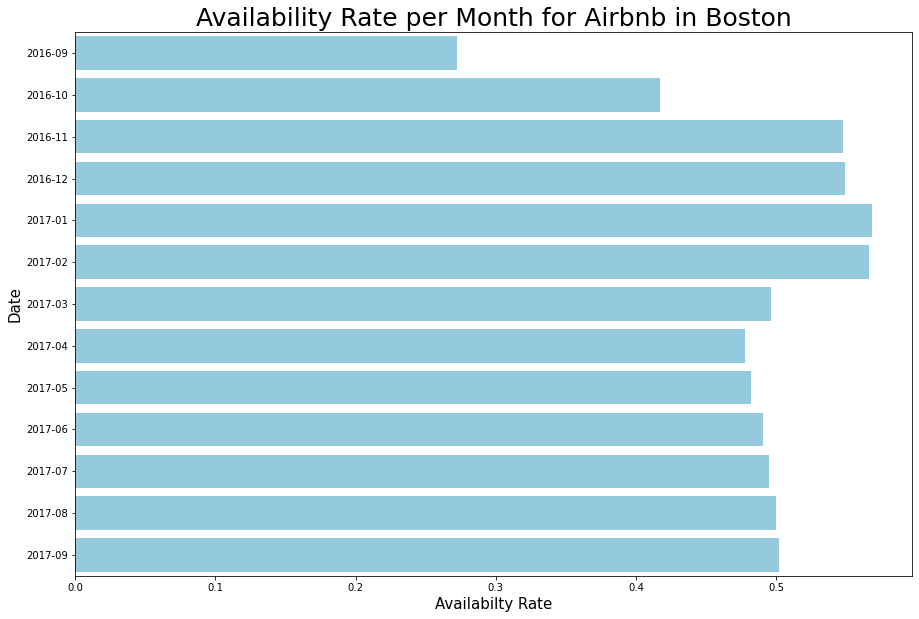

In [171]:
plt.figure(figsize=[15,10])
sns.barplot(y = dict_dfs["calendar"][dict_dfs["calendar"]["available"] == "t"]["year_month"], x = dict_dfs["calendar"][dict_dfs["calendar"]["available"] == "t"]["available_rate"],color="skyblue")
plt.title("Availability Rate per Month for Airbnb in Boston", fontsize = 25)
plt.xlabel("Availabilty Rate", fontsize = 15)
plt.ylabel("Date", fontsize = 15);

## Q2: What are the features on listings which leads to higher reservations

### The answer here will depend on the results from the forth trial

In [187]:
#extracting feauters with postive coefficents
postive_coefs = coefs_df[coefs_df["coefs"] > 0].copy()

In [188]:
#normalizing the coffecients
postive_coefs["norm_coefs"] = (postive_coefs["coefs"]/postive_coefs["coefs"].sum())*100

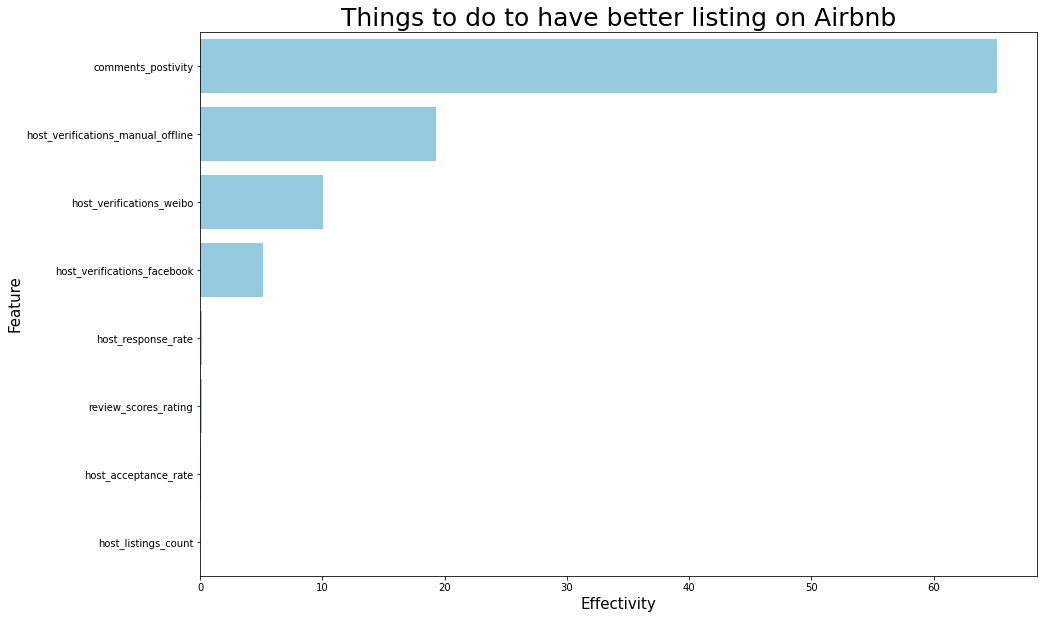

In [190]:
plt.figure(figsize=[15,10])
sns.barplot(x = postive_coefs["norm_coefs"], y = postive_coefs["est_int"],color="skyblue")
plt.title("Things to do to have better listing on Airbnb", fontsize = 25)
plt.xlabel("Effectivity", fontsize = 15)
plt.ylabel("Feature", fontsize = 15);

## Q3: What are the features on listings which leads to lower reservations

### The answer here will depend on the results from the forth trial

In [185]:
#extracting feauters with negtive coefficents
negtive_coefs = coefs_df[coefs_df["coefs"] < 0].copy()

In [186]:
#normalizing the coffecients
negtive_coefs["norm_coefs"] = (negtive_coefs["coefs"]/negtive_coefs["coefs"].sum())*100

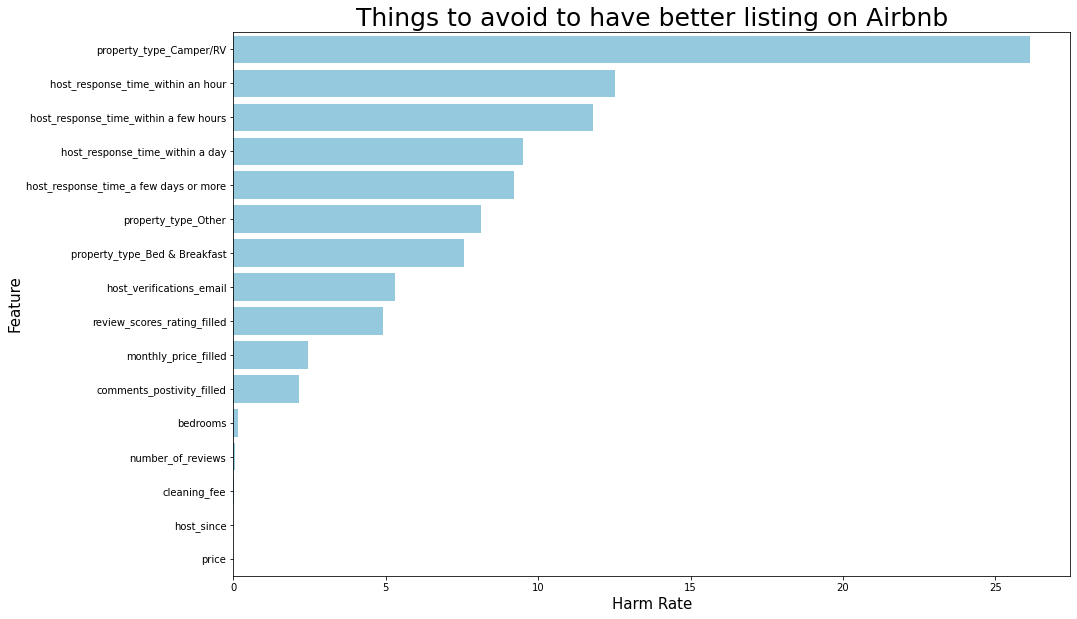

In [193]:
plt.figure(figsize=[15,10])
sns.barplot(x = negtive_coefs["norm_coefs"], y = negtive_coefs["est_int"],color="skyblue")
plt.title("Things to avoid to have better listing on Airbnb", fontsize = 25)
plt.xlabel("Harm Rate", fontsize = 15)
plt.ylabel("Feature", fontsize = 15);